In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import iexfinance.stocks as stocks
import tools.data
import tools.string
import style

<IPython.core.display.Javascript object>

### Scrape tickers from Wikipeida + get company information from IEX
You will need an account to get a token for IEX API

In [3]:
info = tools.data.get_sp500_info()
info.iloc[:2, :8]

,symbol,companyName,exchange,industry,website,description,CEO,securityName
MMM,MMM,3M Co.,"NEW YORK STOCK EXCHANGE, INC.",Offices of Bank Holding Companies ...,https://www.3mindia.in/,,George Buckley,3M Co.
ABT,ABT,Abbott Laboratories,"NEW YORK STOCK EXCHANGE, INC.",Pharmaceutical Preparation Manufacturing ...,https://www.abbott.com,,Robert Ford,Abbott Laboratories


<IPython.core.display.Javascript object>

### Get price data from Yahoo Finance

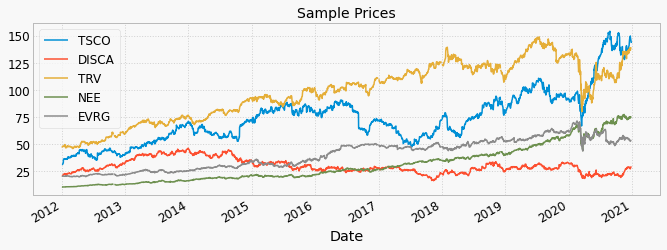

<IPython.core.display.Javascript object>

In [4]:
tickers = info["symbol"].tolist()
start = "2012-01-01"
end = "2020-12-29"
prices = tools.data.get_prices(tickers, start, end)
prices.sample(5, axis=1).plot()
plt.title("Sample Prices")
plt.show()

### Scrape H1B filings from h1bdata.info

In [5]:
functions = ["ANALYTICS", "DATA+SCI", "DATA+ANA", "STATIST", "MACHINE+LEARNING"]
levels = ["JUNIOR", "SENIOR", "LEAD", "STAFF", "MANAGER", "CHIEF", "PRINCIPAL"]
combos = ["+".join([l, f]) for l in levels for f in functions]
search_terms = functions + combos

filings = tools.data.get_h1b(search_terms)
filings.sample(3)

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS
1492,R SYSTEMS INC,DATA SCIENTIST,100000,"DOWNERS GROVE, IL",03/21/2019,09/20/2019,CERTIFIED
391,APPLE INC,MACHINE LEARNING ENGINEER,200000,"CUPERTINO, CA",12/02/2019,12/16/2019,CERTIFIED
382,PHARMACYCLICS LLC,STATISTICAL PROGRAMMER II,86540,"SUNNYVALE, CA",12/22/2016,02/06/2017,CERTIFIED


<IPython.core.display.Javascript object>

### Match company names

In [6]:
from tools.string import standardize_name, StringComparer

iex_names = info["companyName"].apply(standardize_name).tolist()
h1b_names = filings["EMPLOYER"].apply(standardize_name).tolist()
sc = StringComparer(h1b_names, iex_names)
matches = sc.get_matches(threshold=0.75)

h1b_raw = filings["EMPLOYER"].drop_duplicates()
h1b_raw2clean = dict(zip(h1b_raw, h1b_raw.apply(standardize_name)))
iex_raw = info["companyName"].drop_duplicates()
iex_clean2raw = dict(zip(iex_raw.apply(standardize_name), iex_raw))
h1b2iex = matches.set_index("s")["t"].to_dict()
iex2ticker = info.set_index("companyName")["symbol"].to_dict()

filings["TICKER"] = (
    filings["EMPLOYER"]
    .map(h1b_raw2clean)
    .map(h1b2iex)
    .map(iex_clean2raw)
    .map(iex2ticker)
)

String matching complete - 2.97s


<IPython.core.display.Javascript object>

### Clean and explore H1B data
Keep only companies with at least 10 filings

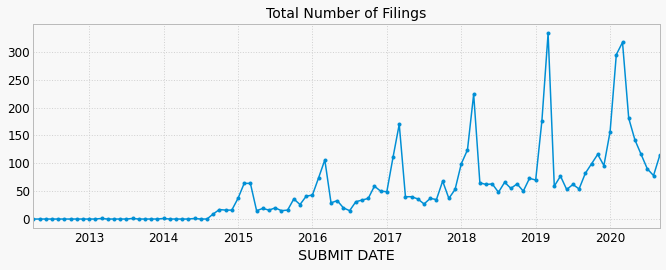

<IPython.core.display.Javascript object>

In [7]:
filings = filings.dropna()
filings["BASE SALARY"] = filings["BASE SALARY"].apply(int)
filings["SUBMIT DATE"] = pd.to_datetime(filings["SUBMIT DATE"])
f = filings.pivot_table(
    columns="EMPLOYER", index="SUBMIT DATE", values="BASE SALARY", aggfunc="count"
)
f = f.loc[:, f.columns[f.sum() >= 10]]
f = f.fillna(0)
plt.title("Total Number of Filings")
f.resample("M").sum().sum(1).plot(marker=".")
f.index.name = None
f.index = f.index - pd.offsets.MonthBegin(4)
f.index = f.index.year
f = f.groupby(f.index).sum()
f = f.iloc[1:-1]
plt.show()

The spike in applications in Q1 is due to the April 1st deadline. We see that the number of H-1B data analysis jobs have been growing consistently in recent years, which 2020 being an exception. COVID-19 might have played a role in this.

#### Aggregate by year
Since new H-1Bs are only processed in April each year, it might be more useful to look at total number of applications from Apr 1 to March 31 of the following year for each company. We should also ignore post-2020 April since it's not complete

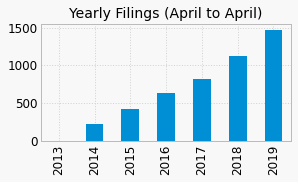

<IPython.core.display.Javascript object>

In [8]:
f.sum(1).plot(kind="bar", width=0.5, figsize=(4, 2))
plt.title("Yearly Filings (April to April)")
plt.show()

#### Heatmap plot

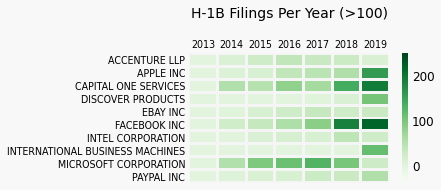

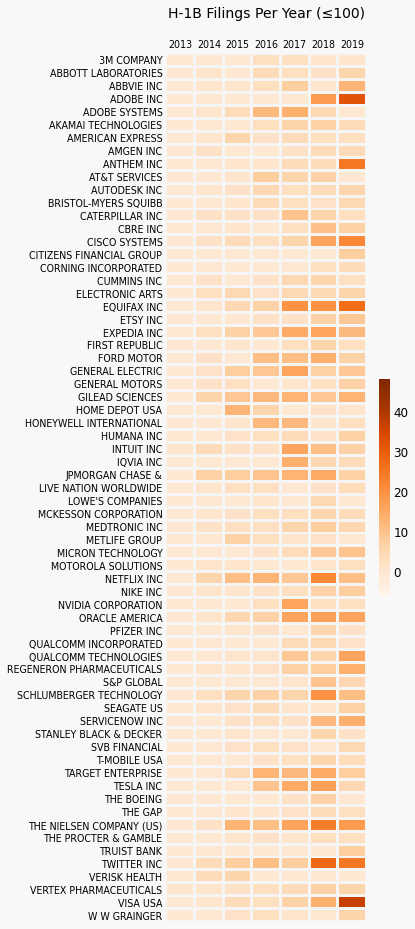

<IPython.core.display.Javascript object>

In [9]:
X1 = f.loc[:, (f.sum() > 100).tolist()]
X1.columns = [" ".join(c.split()[: max(2, len(c.split()) - 1)]) for c in X1.columns]
plt.figure(figsize=(4, X1.shape[1] / 4.5))
plt.tick_params(axis="both", labeltop=True, labelbottom=False, labelsize=9.5)
style_params = dict(linewidths=2, linecolor="#f5f5f5", cbar=True)
sns.heatmap(X1.T, cmap="Greens", vmin=-40, vmax=250, **style_params)
plt.title("H-1B Filings Per Year (>100)\n")
plt.show()

X2 = f.loc[:, (f.sum() <= 100).tolist()]
X2.columns = [" ".join(c.split()[: max(2, len(c.split()) - 1)]) for c in X2.columns]
plt.figure(figsize=(4, X2.shape[1] / 4.5))
plt.tick_params(axis="both", labeltop=True, labelbottom=False, labelsize=9.5)
cbar_kws = dict(shrink=0.25)
style_params = dict(linewidths=2, linecolor="#f5f5f5", cbar=True, cbar_kws=cbar_kws)
sns.heatmap(X2.T, cmap="Oranges", vmin=-6, vmax=48, **style_params)
plt.title("H-1B Filings Per Year (≤100)\n")
plt.show()

#### Largest n filers

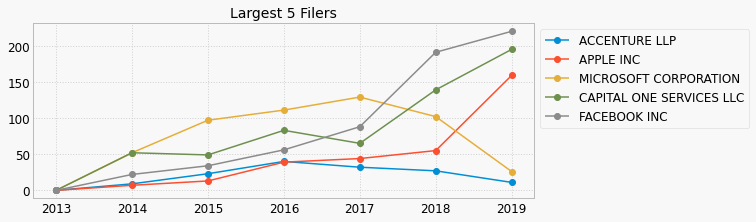

<IPython.core.display.Javascript object>

In [10]:
n = 5
largest = f.sum().sort_values().index[-n:]
f[largest].plot(marker="o", figsize=(8, 3))
plt.title(f"Largest {n} Filers")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

#### Biggest losers(gainers) from peak (trough)

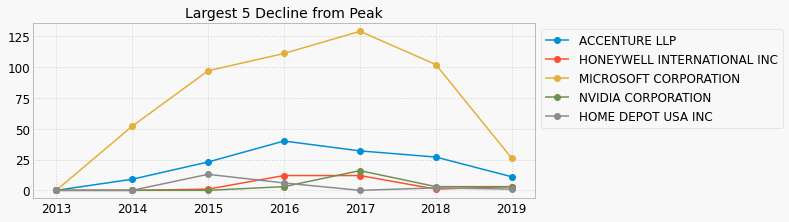

<IPython.core.display.Javascript object>

In [11]:
n = 5
dips = f.apply(lambda x: (x.max() - x.iloc[-1]) / x.max() if x.iloc[-1] > 0 else 0)
biggest_dip = dips.sort_values().index[-n:]
colors = ["r", "b", "g", "orange", "teal"]
f[biggest_dip].plot(marker="o", figsize=(8, 3))
plt.legend(bbox_to_anchor=(1, 0, 1, 1), loc="upper left")
plt.title("Largest 5 Decline from Peak")
plt.show()

### Clustering
To categorize hiring trend into broad categories, we can run clustering algorithms on the time series data. To add additional information, we can perform regression on each time series and use the coefficients as additional features.

In [12]:
from sklearn.linear_model import Lasso

f_norm = f / f.sum()
betas = []
alpha = []
degree = 3
for col in f_norm:
    y = f_norm[col].values
    x = np.arange(len(y))
    variables = np.vstack([x ** d for d in range(1, degree)])
    reg = Lasso(fit_intercept=False)
    reg.fit(variables.T[3:], y[3:])
    betas.append(reg.coef_)
    alpha.append(reg.intercept_)
Z = np.vstack([np.array(alpha), np.array(betas).T])

<IPython.core.display.Javascript object>

Note: the black lines are the cluster averages


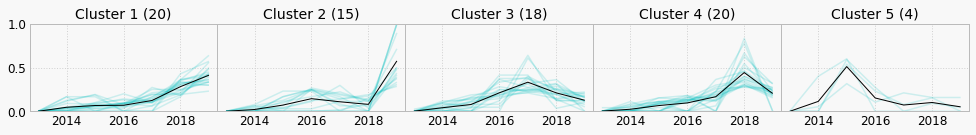

<IPython.core.display.Javascript object>

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

k = 5
X = np.vstack((f_norm.values, Z))
X = StandardScaler().fit_transform(X)
clusterer = KMeans(n_clusters=k, random_state=42)
cluster = clusterer.fit_predict(X.T)

fig, axes = plt.subplots(1, k, figsize=(k * 3, 1.5))
fig.subplots_adjust(wspace=0)
for i, ax in zip(range(k), axes.ravel()):
    data = f_norm.iloc[:, np.where(cluster == i)[0]]
    ax.plot(data, alpha=-0.5 + 1 / len(data) ** 0.2, c="c")
    ax.plot(data.mean(1), c="k", linewidth=1, linestyle="-")
    ax.set_ylim(0, 1)
    ax.set_title(f"Cluster {i+1} ({data.shape[1]})")
    ax.set_yticklabels([]) if i else 0
print("Note: the black lines are the cluster averages")
plt.show()


#### Cluster Interpretation:
* Cluster 1 - spike in 2018 then dip in 2019
* Cluster 2 - spike in 2019
* Cluster 3 - spike in 2016-2018 then gradual decrease
* Cluster 4 - smooth gradual increase
* Cluster 5 - early spikes then decrease and stagnant

#### Comparing against stock returns

Stock returns of companies in each cluster in the period [2018-01-03, 2019-01-03].


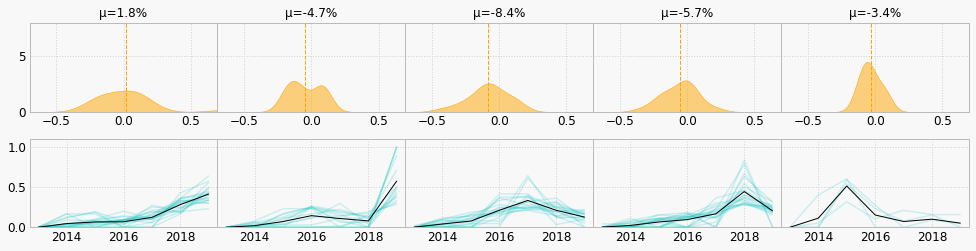

<IPython.core.display.Javascript object>

In [14]:
prices = prices.resample("D").asfreq().fillna(method="bfill").fillna(method="ffill")
start, end = "2018-01-03", "2019-01-03"  # "2019-01-03", "2020-12-23"
multipliers = (prices.loc[end] / prices.loc[start]).fillna(0)
returns = multipliers ** (250 / len(prices.loc[start:end])) - 1

h1b_name2ticker = filings.set_index("EMPLOYER")["TICKER"].to_dict()

fig, axes = plt.subplots(2, k, figsize=(k * 3, 3.5))
fig.subplots_adjust(hspace=0.3, wspace=0)
for i, axe in zip(range(k), axes.T):
    names = f_norm.columns[np.where(cluster == i)[0]]
    tickers = [h1b_name2ticker[name] for name in names]
    ret = returns.loc[tickers]

    ax = axe[0]
    sns.kdeplot(ret, ax=ax, shade=True, color="orange", alpha=0.5)
    ax.axvline(ret.mean(), linewidth=1, linestyle="--", c="orange")
    ax.set_title("μ={:.1%}".format(ret.mean()), fontsize=12)
    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(0, 8)
    ax.set_yticklabels([]) if i else 0
    ax.set_ylabel(None)

    ax = axe[1]
    data = f_norm.iloc[:, np.where(cluster == i)[0]]
    ax.plot(data, alpha=-0.5 + 1 / len(data) ** 0.2, c="c")
    ax.plot(data.mean(1), c="k", linewidth=1, linestyle="-")
    ax.set_ylim(0, 1.1)
    ax.set_yticklabels([]) if i else 0

print(f"Stock returns of companies in each cluster in the period [{start}, {end}].")

### Discussion

**Observations**

- The causal direction can go both ways. Good hiring strategy can lead to profit growth and having good cash flow will lead to more hiring of data professionals (which is a luxury).
- Cluster 1 is the only cluster to have a positive average return. It is reasonable that these companies, who are gradually building up their data capabilities, are also growing very quickly.
- Cluster 2 is the only bimodal cluster. They are characterized by a huge spike in filings, which could be either a desperate attempt by failing companies, or companies who had a great year in 2018.

**Future work**

More work is required to disentangle the effects of other covariates including low-hanging fruits like sector or market-cap.